In [222]:
import tensorflow as tf
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Dense, Subtract, Add, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.constraints import maxnorm
from sklearn.linear_model import Lasso
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn import preprocessing

# The models were done by hour using all the days of the week
data = pd.read_excel("C:/Users/ERIC/Desktop/PML-06MTP-115/06MTP 01012020.xlsm", 1)

# dataset for only the first hour
x = data.iloc[0:87, [1,2,26,50]].values
y = data.iloc[0:87, 74].values

#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 0) #try random_state = 42

#Standarization of the data
'''
sc = StandardScaler()
std_x_train = sc.fit_transform(x_train)
std_x_test = sc.fit_transform(x_test)
'''
# Normalization of the data
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

def create_model():
    # The next model is a sequential one, that means the layers are structured sequantially. 
    
    # Input layer with 4 inputs --> day of the week, demand, generation and the forecast for that day
    input_tensor = Input(shape=(x.shape[1],))
    #layer_drop = Dropout(0.3)
    
    # First hidden layer --> 100 neurons, relu as activation function...receives the input
    hidden_layer = Dense(100, activation = 'relu', kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(input_tensor) #Regularize the wieghts to have better accuracy
    layer_drop = Dropout(0.3) # Dropout certain amount of neurons helping to reduce overfitting
    #Dropout makes the model does not rely on certain neurons making changes in the information processing
    
    # Second hidden layer --> 50 neurons, relu as activation function... receives the first hidden layer
    hidden_layer1 = Dense(50, activation = 'relu',kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer) #Regularize the wieghts to have better accuracy
    layer_drop1 = Dropout(0.3)
    
    # Third hidden layer --> 50 neurons, relu as activation function... receives the second hidden layer
    hidden_layer2 = Dense(50, activation = 'relu',kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer1) #Regularize the wieghts to have better accuracy
    layer_drop2 = Dropout(0.3)
    
    # Fourth hidden layer --> 25 neurons, relu as activation function... receives the third hidden layer
    hidden_layer3 = Dense(25, activation = 'relu', kernel_constraint=maxnorm(3),#Make better results with Dropout
                     kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),#To avoid Over-fitting
                     activity_regularizer=regularizers.l1(0.01))(hidden_layer2) #Regularize the wieghts to have better accuracy
    layer_drop3 = Dropout(0.3)
    
    # 1 ouput ... Receives the last hidden layer
    output_tensor = Dense(1)(hidden_layer3)
    
    # Here the model is created... receiving the four inputs and 1 output
    model = Model(input_tensor, output_tensor)
    
    # Here the model is compiled. Adama is the optimizer in which the learning rate is specified
    # The loss function measures helps in optimizing the parameters of the neural networks
    # The metrics could be an array of measurements but for this case Mean Absolut error is used because is a Regression 
    model.compile(optimizer= Adam(0.003),  loss='mean_absolute_error', metrics = ['mean_absolute_error'])
    return model # the model is returned as a part of the function

n_split=3 # Number of folders the cross-validation is going to be done
 
for train_index,test_index in KFold(n_split).split(x): #in order to start the cross-validation for the training set
    x_train,x_test=x[train_index],x[test_index]
    y_train,y_test=y[train_index],y[test_index]
    model= create_model()
    #Early stopping is a method that allows you to specify an arbitrary large number of training epochs... 
    #...and stop training once the model performance stops improving on a hold out validation dataset
    monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto', 
                        restore_best_weights = True)
    # Assigning to variable history the fitting process
    #model.fit(training_dataset_x, training_dataset_y, early_stopping, number of iterations, quantity of data
    #used in each epoch, percentage of error for validation (20% this case), if we want to see the process Verbose = 1)
    history = model.fit(x_train,
          y_train,
          #validation_data = (x_test, y_test),
          callbacks = [monitor],
          epochs=200,
          batch_size = 3,
          validation_split = 0.2,
          verbose=0)
    print('Model evaluation ',model.evaluate(x_test,y_test)) # Evalution of the model using the loss function and metrics

Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
29/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 17ms/sample - loss: 74.1898 - mean

In [223]:
from sklearn.metrics import r2_score
# Prediction for the test set
pred = model.predict(x_test)

# Root squared error between prediction and the real values of LMP from the test set
score = np.sqrt(mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

# Prediction for the training set
pred_train = model.predict(x_train)

# R^{2} returns a value which represents the relation betwen the data
print("R^2 on training set is {}".format(r2_score(y_train, pred_train)))
print("R^2 on testing set is {}".format(r2_score(y_test, pred)))

# Showing the prediction and the real values for the LMP in the test set
pred = pd.DataFrame(pred)
pred.columns = ['Prediction']
y_test = pd.DataFrame(y_test)
y_test.columns = ['Real Value']
results = pd.concat([pred,y_test], axis =1)
results


Final score (RMSE): 96.56601676045426
R^2 on training set is -0.029638320762609416
R^2 on testing set is 0.15200261175742713


,Prediction,Real Value
0,295.135864,306.40
1,304.862457,287.72
2,277.777374,88.07
3,241.028320,271.31
4,331.133179,445.00
5,344.601776,339.08
6,332.167328,292.83
7,319.435883,314.77
8,323.889252,325.61
9,278.696289,281.02


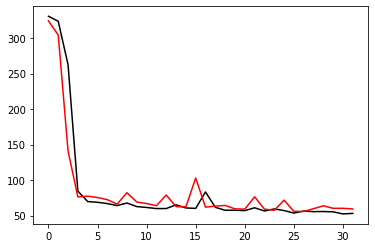

In [224]:
#visualization for the preformance between the training set an its validation set,
#This helps to see when the model is overfitting
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.figure()
plt.plot(loss_values, 'k', label = 'training_loss')
plt.plot(val_loss_values, 'r', label = 'val training loss')


In [225]:
x_f = data.iloc[10:, [1,2,26,50]].values
min_max_scaler = preprocessing.MinMaxScaler()
x_f = min_max_scaler.fit_transform(x_f)

forecast = model.predict(x_f)
forecast = pd.DataFrame(forecast)
forecast.columns = ['Forecast']
forecast


,Forecast
0,313.815308
1,276.938751
2,248.215622
3,294.508667
4,303.905060
...,...
74,383.837036
75,404.414459
76,393.082489
77,375.153534
